In [1]:
from base_dataset import BaseDataset

from torchvision import transforms
import numpy as np
from PIL import Image
import cv2

from util import gen_trimap, gen_trimap_with_dilate, gen_trimap_with_dilate_bbox

/home/ubuntu/miniconda3/envs/hrnet/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [809]:
# root_dir = '/home/ubuntu/data/workspace/deeplabv3_plus/people_segmentation'
# ds = BaseDataset(root_dir, img_dir="images", alpha_dir="masks")

5678 samples


In [985]:
# ds = BaseDataset( "/home/ubuntu/data/yong/projects/MODNet/data/PPM-100",
#         "image",
#         "matte")

100 samples


In [1005]:
# ds = BaseDataset( "/home/ubuntu/data/yong/projects/P3M/data/P3M-10k/train",
#         "blurred_image",
#         "mask")

9421 samples


In [1039]:
# ds = BaseDataset( "/home/ubuntu/data/yong/dataset/Human-Segmentation-Dataset",
#         "Training_Images",
#         "Ground_Truth")

290 samples


In [1078]:
# ds = BaseDataset( "/home/ubuntu/data/yong/dataset/human_matting_dataset_kaggle",
#         "JPEGImages",
#         "SegmentationClassPNG")

428 samples


In [1109]:
# ds = BaseDataset( "/home/ubuntu/data/yong/dataset/segmentation_full_body_mads_dataset_1192_img",
#         "images",
#         "masks")

1192 samples


In [1199]:
# ds = BaseDataset( "/home/ubuntu/data/yong/dataset/RealWorldPortrait-636",
#         "image",
#         "alpha")

636 samples


In [1230]:
ds = BaseDataset("/home/ubuntu/data/yong/dataset/people_segmentation",
        "images",
        "profiles")

5387 samples


In [1231]:
sample = ds[50]

/home/ubuntu/data/yong/dataset/people_segmentation/profiles/00358-profile.jpg


In [1232]:
alpha_path, weight, img, trimap, alpha = sample

In [1233]:
alpha = np.array(Image.open(alpha_path))
if alpha.shape[-1] == 4:
    if len(np.unique(alpha[..., -1])) == 1:
        alpha = alpha[..., :-1]
alpha = alpha[..., -1] if len(alpha.shape) > 2 else alpha

if 'profile' in alpha_path:
    alpha = 255 - alpha

In [1234]:
if np.amax(alpha) <= 1:
    alpha = alpha * 255.0

In [1235]:
# Image.fromarray(np.array(alpha, dtype=np.uint8))

In [1236]:
np.unique(alpha)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  39,
       216, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229,
       230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242,
       243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255],
      dtype=uint8)

In [1237]:
import random

In [1238]:
def get_bbox(alpha):
    foreground = alpha > 0.0
    res = None
    res = Image.fromarray(foreground).getbbox()
    if res is None:
        left, upper, right, ylower = 0, 0, alpha.shape[1], alpha.shape[0]
    else:
        left, upper, right, ylower = res
    return (left, upper, right, ylower)

In [1239]:
def draw_bbox(alpha):
    rect = get_bbox(alpha)
    rect_width = rect[2] - rect[0]
    rect_height = rect[3] - rect[1]
    res = cv2.rectangle(np.array(alpha, dtype=np.uint8), rect[:2], rect[2:], color = 128, thickness =2)
    return res

In [1240]:
# res  = draw_bbox(alpha)
# Image.fromarray(np.array(res, dtype=np.uint8))

(0, 43, 542, 700)


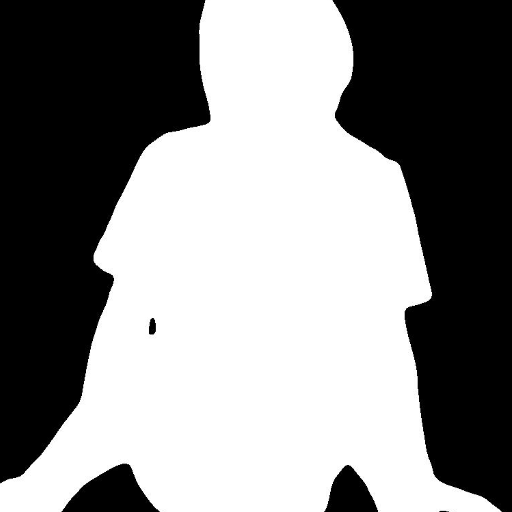

In [1257]:
def resize_and_crop_by_alpha(alpha, ref_size = 512, random_scale = 1.5):
    rect = get_bbox(alpha)
    rect_width = rect[2] - rect[0]
    rect_height = rect[3] - rect[1]

    im_h, im_w = alpha.shape

    # 先取alpha的BBOX
    ## 如果BBOX的长边过小(不足ref_size的一半），则放大BBOX长边到(ref_size // 2, ref_size)
    random_size = np.random.randint(ref_size // 2, ref_size - 1)
    if rect_width >= rect_height:
        r_scale = random_size / rect_width
    else:
        r_scale = random_size / rect_height
    r_scale = 1 if r_scale < 1 else r_scale
    im_rw = int(im_w * r_scale)
    im_rh = int(im_h * r_scale)
    # print(f'phase 1: {im_rh, im_rw}')
    ## 如果放大后的图片短边不足ref_size，或者之前没有放大
    ## 则将图片短边Resize到(ref_size, ref_size * 1.5)
    if min(im_rh, im_rw) < ref_size or r_scale == 1:
        random_size = np.random.randint(ref_size, int(ref_size * random_scale))
        if im_rw >= im_rh:
            im_rw = int(im_rw / im_rh * random_size)
            im_rh = random_size
        elif im_rw < im_rh:
            im_rh = int(im_rh / im_rw * random_size)
            im_rw = random_size
        # print(f'phase 2: {im_rh, im_rw}')
    
    # img = cv2.resize(img, (im_rw, im_rh), interpolation=cv2.INTER_LINEAR)
    alpha = cv2.resize(alpha, (im_rw, im_rh), interpolation=cv2.INTER_LINEAR)
    rect = get_bbox(alpha)
    rect_width = rect[2] - rect[0]
    rect_height = rect[3] - rect[1]
    print(rect)
    # print(f'new rect height, wdith: {rect_height, rect_width}')

    # random crop
    x0 = random.randint(max(0, rect[0] - ref_size), min(im_rw - ref_size, rect[2]))
    y0 = random.randint(max(0, rect[1] - ref_size), min(im_rh - ref_size, rect[3]))

    # img = img[y0:y0 + ref_size, x0:x0 + ref_size, ...]
    alpha = alpha[y0:y0 + ref_size, x0:x0 + ref_size, ...]
    
    return alpha

res = resize_and_crop_by_alpha(alpha)
Image.fromarray(np.array(res, dtype=np.uint8))